Author: Zirui Zheng

## Pre-processing

In [136]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import glob
import numpy as np
import datetime
import time
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import skimage.io
import statsmodels.api as sm
import itertools
from pylab import rcParams
import spacy
nlp = spacy.load('en')
%matplotlib inline

In [2]:
paths = glob.glob('./data/*.xlsx')
df = pd.ExcelFile(paths[0]).parse(0)
for path in paths[1:]:
    tmp = pd.ExcelFile(path).parse(0)
    df = pd.concat([df, tmp], ignore_index=True)

In [3]:
df.shape

(512821, 41)

In [4]:
#Remove duplicates
data = df.drop_duplicates()

#Drop na and 60% empty columns
data = data.dropna(how='all', subset=['Sound Bite Text', 'No. of Followers/Daily Unique Visitors'])
drop_cols=[]
for col in df.columns:
    if df[col].isna().sum() > df.shape[0] * 0.4:
        drop_cols.append(col)
        
data = data.drop(columns=drop_cols)

#Keep only original posts
data = data[data['Post Type'] == 'Original']

# drop rows with review text deleted
data.drop(data[(data["Sound Bite Text"] == "Post deleted by the author.")].index, inplace=True)

#Convert Date
data = data.rename(columns = {'Published Date (GMT-04:00) New York':'Date'})
data['Date'] = pd.to_datetime(data['Date'],format="%b %d, %Y %I:%M:%S %p").dt.date

## Get Sentiment before and after launch

In [5]:
def get_sentiment(text): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(clean_text(text)) 
        # set sentiment 
        return analysis.sentiment.polarity

In [6]:
def clean_text(text): 
        ''' 
        Utility function to clean text by removing links, special characters 
        using simple regex statements. 
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())

In [7]:
def populate_sentiment(data):
    sent = []
    for i in range(len(data)):
        sent.append(get_sentiment(data.iloc[i]['Sound Bite Text']))
    return sent

In [8]:
data['Sentiment'] = populate_sentiment(data)

In [45]:
#Constant variables to use
kw_dict = {'apple':['iphone', 'apple', 'ios', 'plus'], 
           'samsung':['samsung', 'galaxy', 's8', 'note', 's7'], 
           'apple iphone x':['iphone x', 'iphone 10', 'iphonex', 'iphone10'], 
           'apple iphone 8': ['iphone 8', 'iphone8', 'plus']}
lc_dates = {'apple':datetime.date(2017,9,22), 'samsung':datetime.date(2017,3,29)}
start_dates = {'apple':datetime.date(2017,9,1), 'samsung':datetime.date(2017,3,1)}
end_dates = {'apple':datetime.date(2017,11,1), 'samsung':datetime.date(2017,7,1)}
products = ['Galaxy S8','Apple','Apple iPhone X', 'Apple iPhone 8']
genders = ['Female', 'Male']

In [46]:
def product_sentiment_launch_diff(data, prod):
    product = ''
    if prod == 'galaxy s8':
        product = 'samsung'
    else:
        product = prod
    data = data[data['Sound Bite Text'].str.contains('|'.join(kw_dict[product]), case=False)]
    
    brand = str.split(product, ' ')[0]
    lcdate, start, end = lc_dates[brand], start_dates[brand], end_dates[brand]
    prelaunch_df = data[(data['Date'] >= start) & (data['Date'] < lcdate)]
    postlaunch_df = data[(data['Date'] >= lcdate) & (data['Date'] <= end)]
    
    print('Pre_launch sentiment for %s is %s' %(prod, sum(prelaunch_df['Sentiment'])/len(prelaunch_df['Sentiment'])))
    print('Post_launch sentiment for %s is %s' %(prod, sum(postlaunch_df['Sentiment'])/len(postlaunch_df['Sentiment'])))
    
    return prelaunch_df, postlaunch_df

In [47]:
def display_sentiment_trend_products(data, products):
    result_dfs = []
    for p in products:
        pre_df, post_df = product_sentiment_launch_diff(data, p.lower())
        result_dfs.append(pre_df)
        result_dfs.append(post_df)
    
    num_dfs = len(result_dfs)
        
    fig, axes = plt.subplots(num_dfs//2, 2, sharey='row', figsize=(15, 4*num_dfs))
    fig.suptitle('Sentiment Analysis: Difference before and after product launch')
    for i in range(0, num_dfs, 2):
        axes[i//2][i%2].plot(result_dfs[i].groupby(['Date'])['Sentiment'].mean())
        axes[i//2][i%2].set(ylabel='Sentiment')
        axes[i//2][i%2].set_title('Pre Launch for ' + products[i//2].capitalize())
        axes[i//2][i%2+1].plot(result_dfs[i+1].groupby(['Date'])['Sentiment'].mean())
        axes[i//2][i%2+1].set_title('Post Launch for ' + products[i//2].capitalize())

Pre_launch sentiment for galaxy s8 is 0.12352837378992865
Post_launch sentiment for galaxy s8 is 0.16044840206582073
Pre_launch sentiment for apple is 0.15276946583856651
Post_launch sentiment for apple is 0.1564104993565205
Pre_launch sentiment for apple iphone x is 0.14987027636894115
Post_launch sentiment for apple iphone x is 0.14985658472164365
Pre_launch sentiment for apple iphone 8 is 0.15281636914219696
Post_launch sentiment for apple iphone 8 is 0.15637849490163264


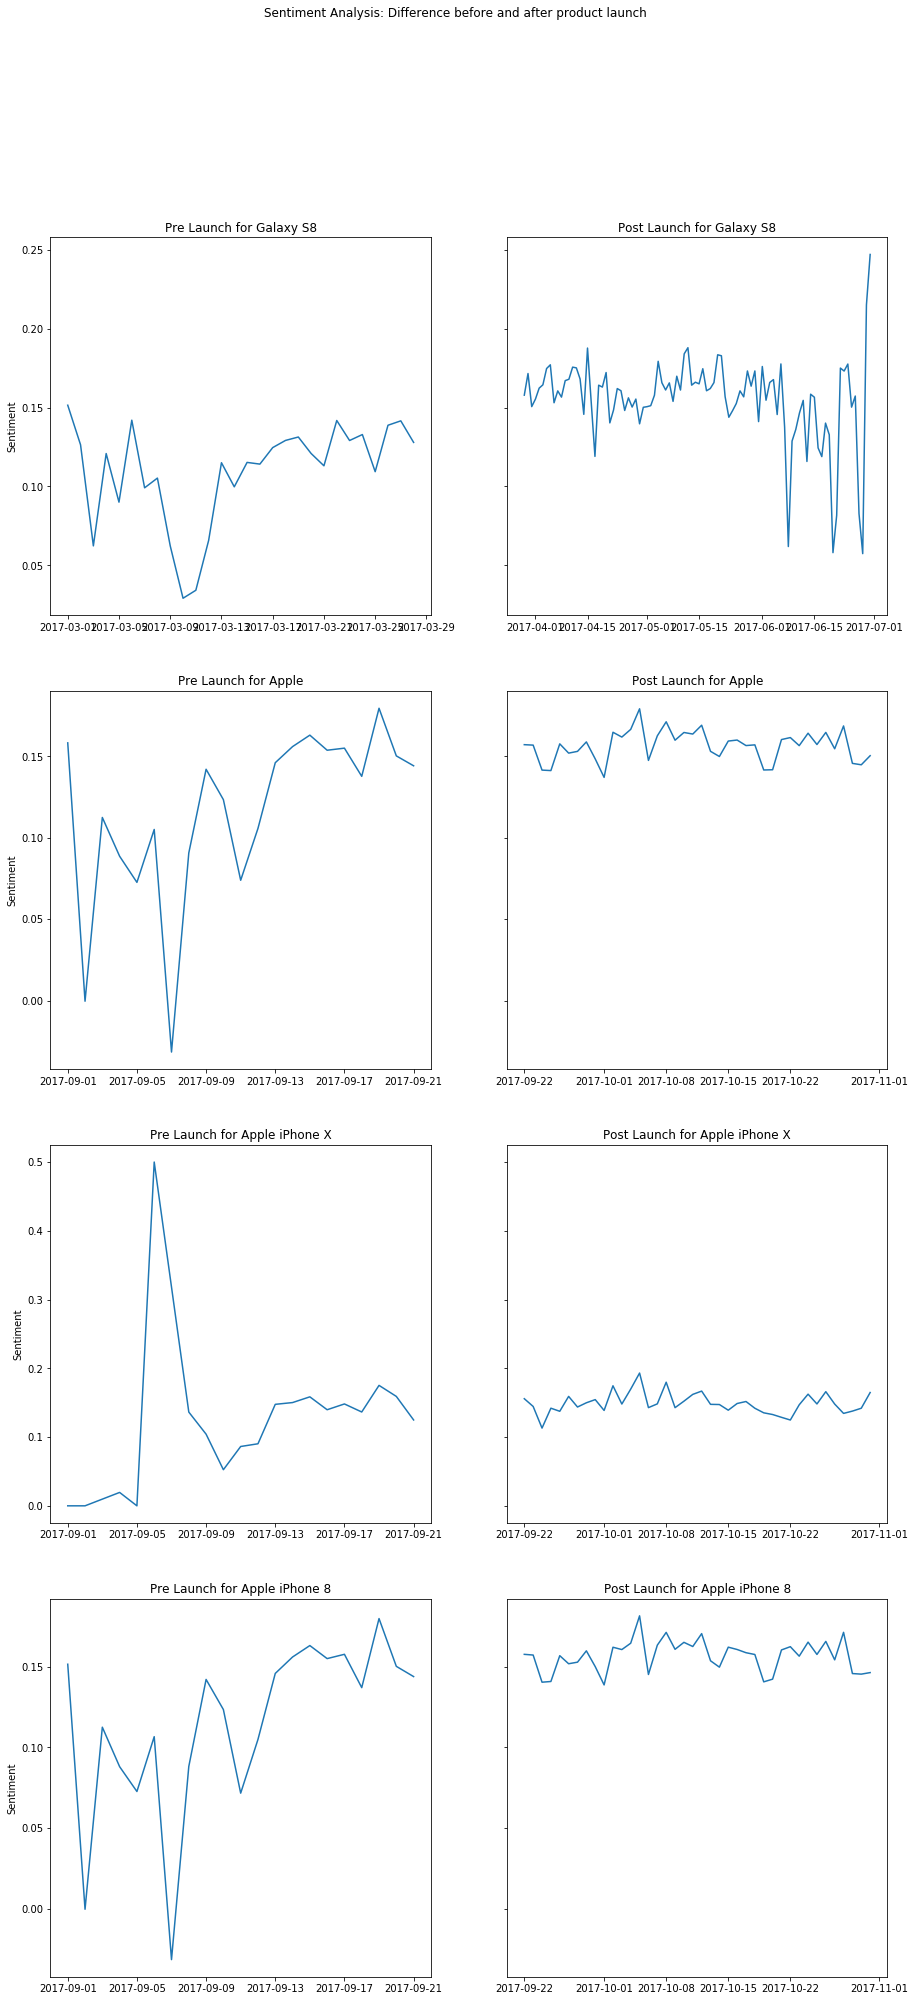

In [50]:
normal_user_data = data[data['No. of Followers/Daily Unique Visitors'] <= 2000]
display_sentiment_trend_products(normal_user_data, products)

## Get Sentiment from professionals and celebrities
(followers > 2000)

In [51]:
def product_sentiment_influencers(data, has_large_follower, prod):
    product = ''
    if prod == 'galaxy s8':
        product = 'samsung'
    else:
        product = prod
    data = data[data['Sound Bite Text'].str.contains('|'.join(kw_dict[product]), case=False)]
    
    customer = ''
    
    if has_large_follower:
        data = data[data['No. of Followers/Daily Unique Visitors'] > 2000]
        customer = 'professionals and celebrities'
    else:
        data = data[data['No. of Followers/Daily Unique Visitors'] <= 2000]
        customer = 'normal users'
    
    
    brand = str.split(product, ' ')[0]
    start, end = start_dates[brand], end_dates[brand]
    data = data[(data['Date'] >= start) & (data['Date'] <= end)]

    print('Sentiment from %s for %s is %s' 
          %(customer, prod, sum(data['Sentiment'])/len(data['Sentiment'])))
    
    return data

In [52]:
def display_infdata_products(data, products):
    result_dfs = []
    has_large_follower = [False, True]
    for p in products:
        for b in has_large_follower:
            df = product_sentiment_influencers(data, b, p.lower())
            result_dfs.append(df)
    
    num_dfs = len(result_dfs)
    
    labels = ['Professionals and Celebrities', 'Normal Users']
        
    fig, axes = plt.subplots(num_dfs//2, 1, figsize=(15, 4*num_dfs))
    fig.suptitle('Sentiment Analysis: Difference for incluencers and normal users')
    for i in range(0, num_dfs, 2):
        axes[i//2].plot(result_dfs[i].groupby(['Date'])['Sentiment'].mean())
        axes[i//2].set(ylabel='Sentiment')
        axes[i//2].set_title('Comparison for ' + products[i//2].capitalize())
        axes[i//2].plot(result_dfs[i+1].groupby(['Date'])['Sentiment'].mean())
        axes[i//2].legend(labels)

Sentiment from normal users for galaxy s8 is 0.15618756331572797
Sentiment from professionals and celebrities for galaxy s8 is 0.1497094879745859
Sentiment from normal users for apple is 0.15539883289762932
Sentiment from professionals and celebrities for apple is 0.15915490906016588
Sentiment from normal users for apple iphone x is 0.149862811092332
Sentiment from professionals and celebrities for apple iphone x is 0.14783946010434815
Sentiment from normal users for apple iphone 8 is 0.1553868951677799
Sentiment from professionals and celebrities for apple iphone 8 is 0.1594401469986767


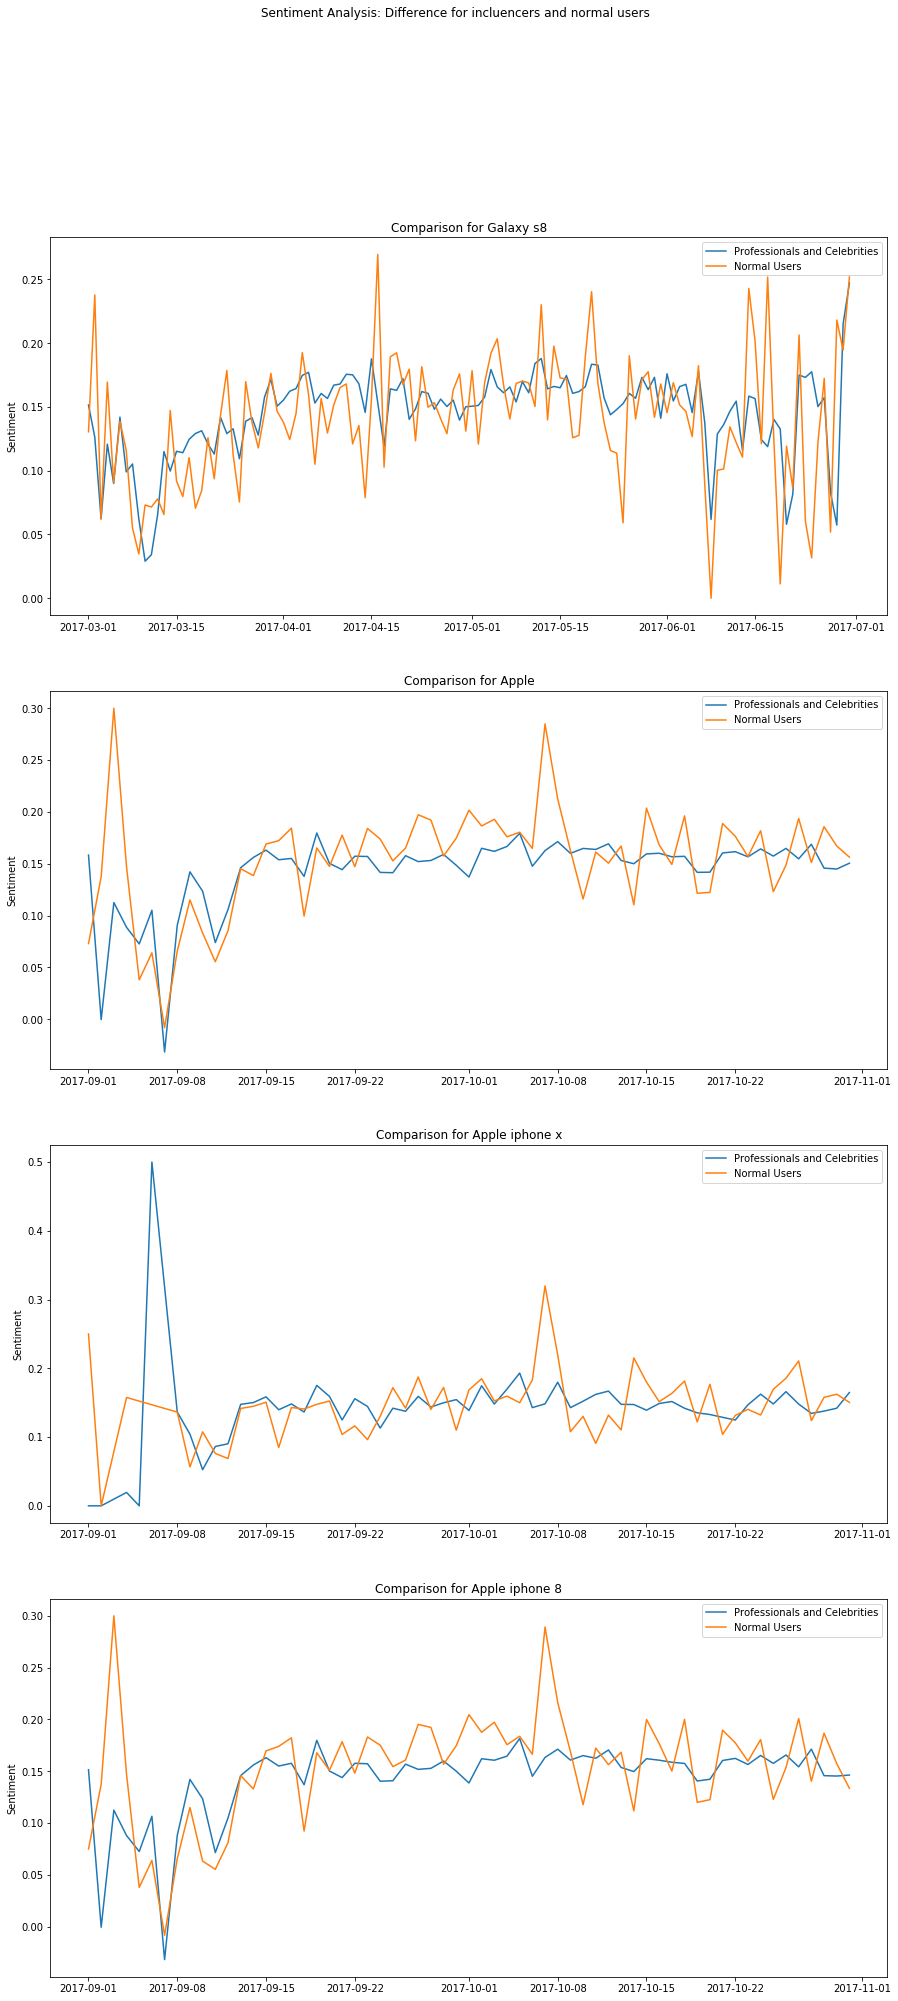

In [53]:
display_infdata_products(data, products)

## Get Sentiment from Female and Male

In [54]:
def product_sentiment_gender(data, gender, prod):
    product = ''
    if prod == 'galaxy s8':
        product = 'samsung'
    else:
        product = prod
    data = data[(data['Sound Bite Text'].str.contains('|'.join(kw_dict[product]), case=False)) & (data['Author Gender']==gender)]
    
    brand = str.split(product, ' ')[0]
    start, end = start_dates[brand], end_dates[brand]
    data = data[(data['Date'] >= start) & (data['Date'] <= end)]

    print('Sentiment from %s for %s is %s' 
          %(gender, prod, sum(data['Sentiment'])/len(data['Sentiment'])))
    
    return data

In [55]:
def display_gender_products(data, genders, products):
    result_dfs = []
    for product in products:
        for gender in genders:
            result_dfs.append(product_sentiment_gender(data, gender, product.lower()))
    
    num_dfs = len(result_dfs)
    
    labels = genders
        
    fig, axes = plt.subplots(num_dfs//2, 1, figsize=(15, 4*num_dfs))
    fig.suptitle('Sentiment Analysis: Difference across genders')
    for i in range(0, num_dfs, 2):
        axes[i//2].plot(result_dfs[i].groupby(['Date'])['Sentiment'].mean())
        axes[i//2].set(ylabel='Sentiment')
        axes[i//2].set_title('Comparison for ' + products[i//2].capitalize())
        axes[i//2].plot(result_dfs[i+1].groupby(['Date'])['Sentiment'].mean())
        axes[i//2].legend(labels)

In [56]:
print(len(data[data['Author Gender']=='Female']), len(data[data['Author Gender']=='Male']))

15892 56324


Sentiment from Female for galaxy s8 is 0.16969547541060595
Sentiment from Male for galaxy s8 is 0.15924996557517995
Sentiment from Female for apple is 0.17424944020363728
Sentiment from Male for apple is 0.1587848285871648
Sentiment from Female for apple iphone x is 0.15419618138718447
Sentiment from Male for apple iphone x is 0.1528529080931287
Sentiment from Female for apple iphone 8 is 0.17429526451366825
Sentiment from Male for apple iphone 8 is 0.15866226183409618


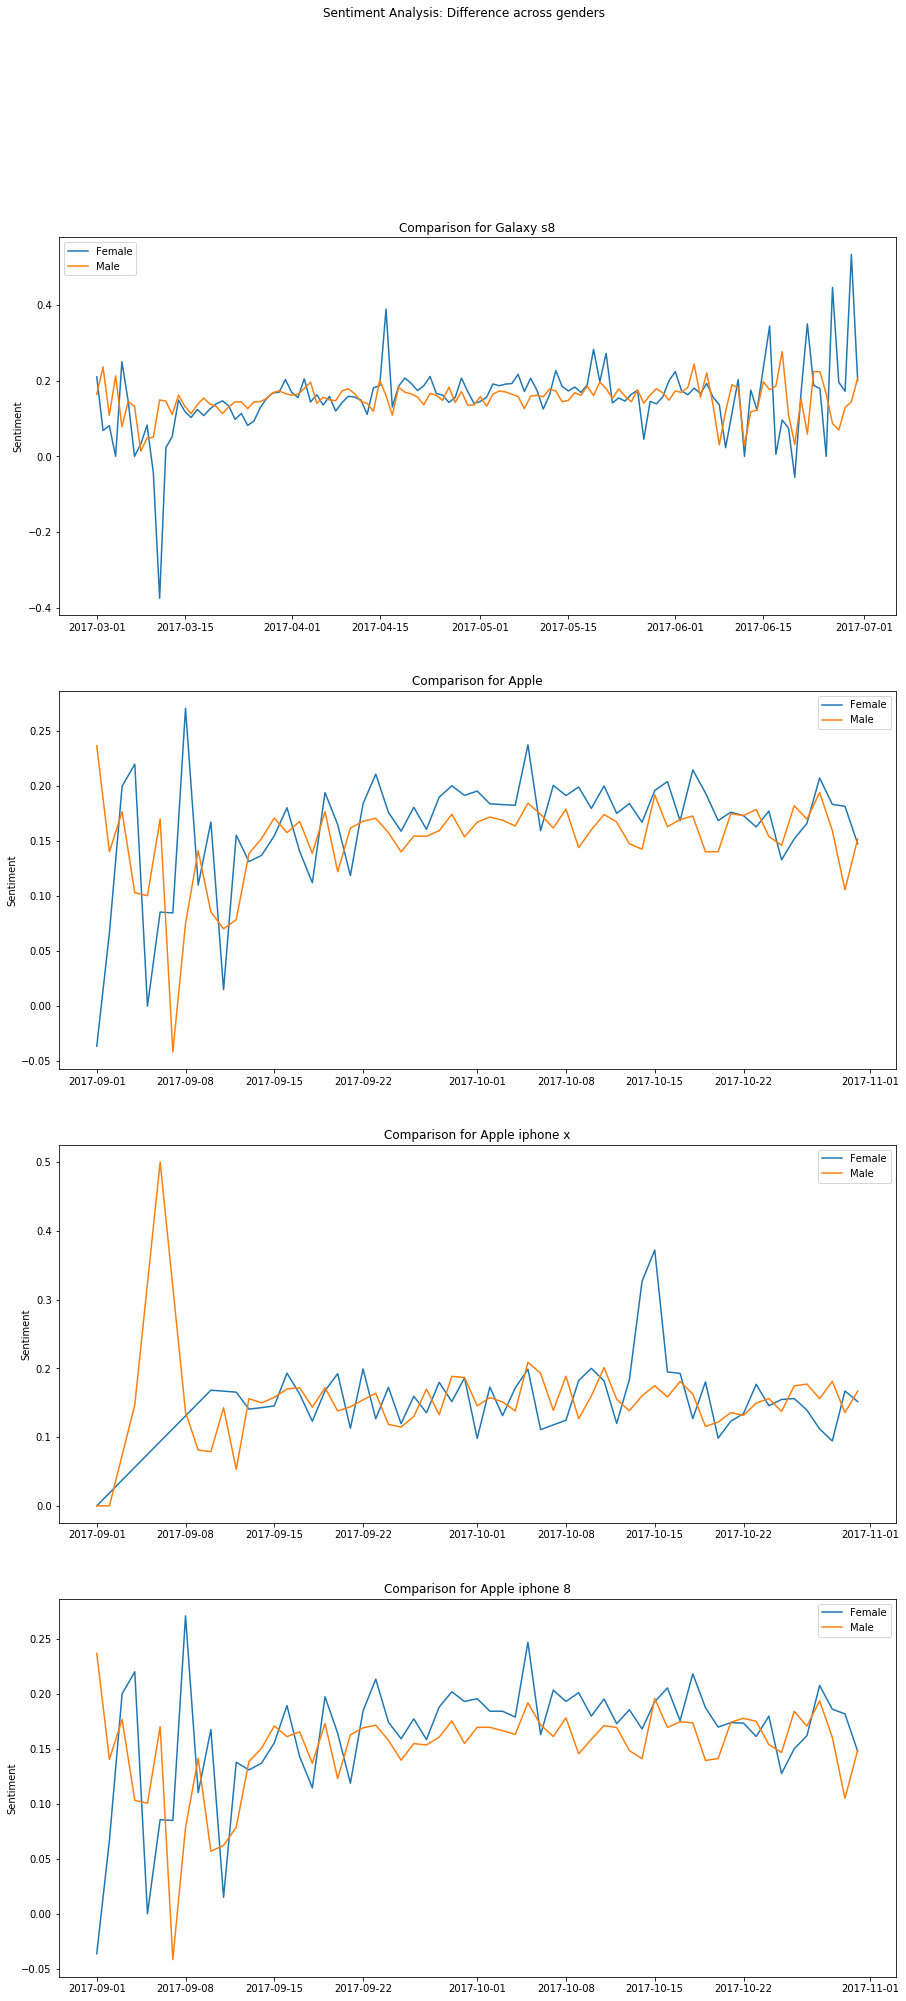

In [57]:
display_gender_products(data, genders, products)

## Get Sentiment across twitter / non-twitter platforms

In [58]:
def product_sentiment_platform(data, platform, prod):
    product = ''
    if prod == 'galaxy s8':
        product = 'samsung'
    else:
        product = prod
    brand = str.split(product, ' ')[0]
    start, end = start_dates[brand], end_dates[brand]
    data = data[(data['Date'] >= start) & (data['Date'] <= end) 
                & (data['Sound Bite Text'].str.contains('|'.join(kw_dict[product]), case=False))]
    
    if platform == 'Twitter':
        data = data[data['Source Type']=='Twitter']
    else:
        data = data[data['Source Type']!='Twitter']

    print('Sentiment from %s for %s is %s' 
          %(platform, prod, sum(data['Sentiment'])/len(data['Sentiment'])))
    
    return data

In [59]:
def display_platform_products(data, products):
    platform_list = ['Twitter', 'Other Sources']
    result_dfs = []
    for product in products:
        for platform in platform_list:
            result_dfs.append(product_sentiment_platform(data, platform, product.lower()))
    
    num_dfs = len(result_dfs)
    
    labels = platform_list
    
    fig, axes = plt.subplots(num_dfs//2, 1, figsize=(15, 4*num_dfs))
    fig.suptitle('Sentiment Analysis: Difference across platforms')
    for i in range(0, num_dfs, 2):
        axes[i//2].plot(result_dfs[i].groupby(['Date'])['Sentiment'].mean())
        axes[i//2].set(ylabel='Sentiment')
        axes[i//2].set_title('Comparison for ' + products[i//2].capitalize())
        axes[i//2].plot(result_dfs[i+1].groupby(['Date'])['Sentiment'].mean())
        axes[i//2].legend(labels)

Sentiment from Twitter for galaxy s8 is 0.13879415400405992
Sentiment from Other Sources for galaxy s8 is 0.15750888699747684
Sentiment from Twitter for apple is 0.1268158637501971
Sentiment from Other Sources for apple is 0.15672586167481506
Sentiment from Twitter for apple iphone x is 0.1473065584596799
Sentiment from Other Sources for apple iphone x is 0.14979859839242654
Sentiment from Twitter for apple iphone 8 is 0.12507807518964428
Sentiment from Other Sources for apple iphone 8 is 0.15681848888610456


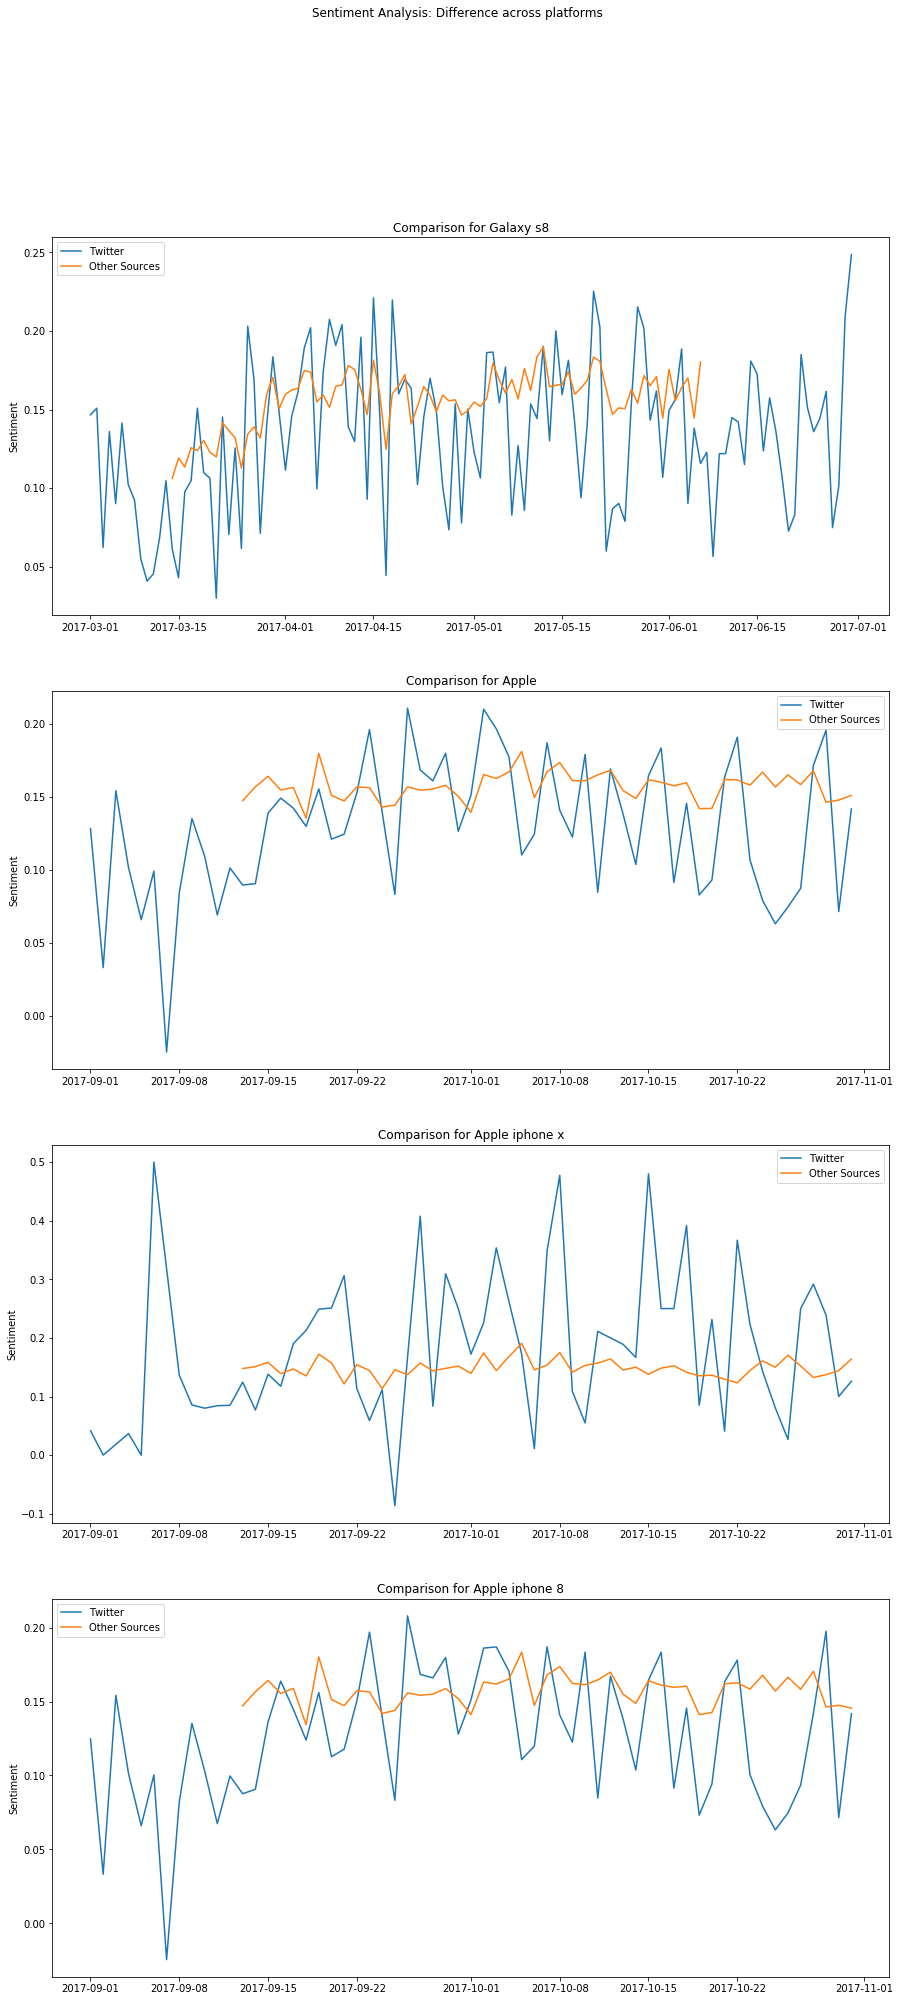

In [60]:
display_platform_products(data, products)

## Sentiment on different Media Type

In [106]:
sentiment_media_type = data.groupby('Media Type').filter(lambda x : len(x) > 100).groupby('Media Type')['Sentiment'].mean()
sentiment_media_type = sentiment_media_type.sort_values(ascending = False)

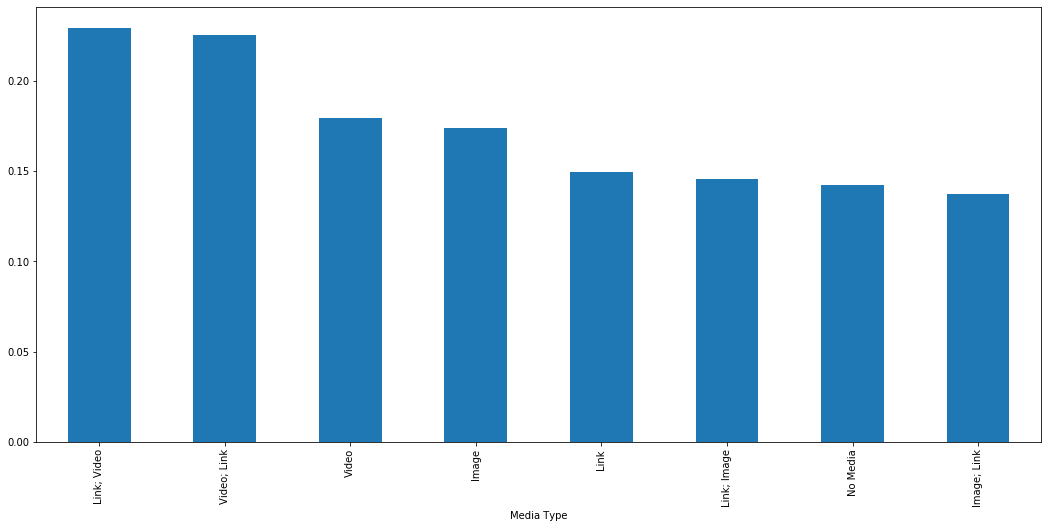

In [107]:
sentiment_media_type.plot(kind='bar')

## WordCloud for good and bad sentiment

In [67]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS
stopwords.add('iphone')
stopwords.add('samsung')
stopwords.add('PRON')
stopwords.add('apple')
stopwords.add('plus')
stopwords.add('phone')
stopwords.add('8')
stopwords.add('x')
stopwords.add('s')
stopwords.add('t')
stopwords.add('ift')
stopwords.add('tt')
stopwords.add('http')
stopwords.add('galaxy')
stopwords.add('smartphone')
stopwords.add('s7')
stopwords.add('s8')
stopwords.add('lg')
stopwords.add('g6')
stopwords.add('https')
stopwords.add('Twitter')
stopwords.add('pic twitter')
stopwords.add('Tags')
stopwords.add('IFTTT')
stopwords.add('Tags IFTTT')
stopwords.add('com')
stopwords.add('ha')

In [68]:
def extract_keywords(text_list):
    good_list, bad_list = [], []
    for i in range(len(text_list)):
        # create TextBlob object of passed tweet text 
        text = text_list[i]
        analysis = TextBlob(clean_text(text)) 
        # set sentiment 
        sent = analysis.sentiment.polarity
        words = analysis.words

        # add the lemma of the word
        if sent > 0.2:
            for w in words:
                good_list.append(w.lemmatize())
        elif sent < -0.2:
            for w in words:
                bad_list.append(w.lemmatize())
    return good_list, bad_list

In [69]:
def display_wordcloud(wc_dict):
    products = ['apple', 'samsung']
    senses = ['good', 'bad']
    fig, axes = plt.subplots(2,2,figsize=(20,20)) 
    for i in range(2):
        p = products[i]
        mask_path = p + '.png'
        mask = skimage.io.imread(mask_path)
        for j in range(2):
            word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, 
                    background_color="white", stopwords=stopwords, max_words=2000,
                    contour_width=1, contour_color="steelblue", mask=mask,
                    colormap="nipy_spectral").generate(' '.join(wc_dict[p][j]))
            axes[i][j].imshow(word_cloud, interpolation="hermite")
            axes[i][j].set_title('Word Cloud for %s with %s sentiment' % (p.capitalize(), senses[j]))
            axes[i][j].axis("off")
    plt.show() 

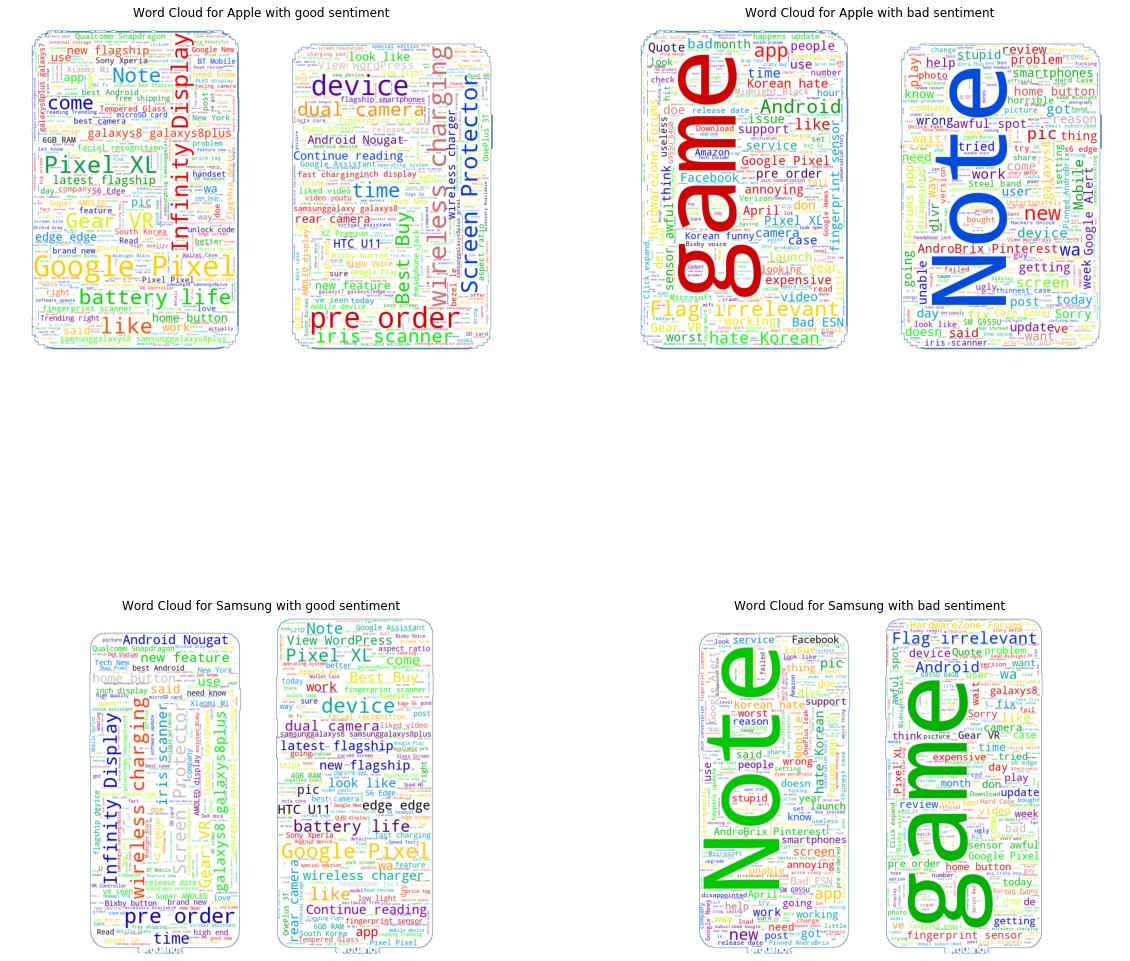

In [70]:
text_list = list(data['Sound Bite Text'])
samsung_data = data[data['Sound Bite Text'].str.contains('|'.join(kw_dict['samsung']), case=False)]
samsung_good, samsung_bad = extract_keywords(list(samsung_data['Sound Bite Text']))
apple_data = data[data['Sound Bite Text'].str.contains('|'.join(kw_dict['apple']), case=False)]
apple_good, apple_bad = extract_keywords(list(samsung_data['Sound Bite Text']))
display_wordcloud({'apple':[apple_good, apple_bad], 'samsung':[samsung_good, samsung_bad]})

## Time Series

In [117]:
def extract_time_series_data(data, prod):
    # use only normal users
    data[data['No. of Followers/Daily Unique Visitors'] <= 2000]
    
    # get those only for samsung
    data = data[data['Sound Bite Text'].str.contains('|'.join(kw_dict[prod]), case=False)]
    
    # keep only 'Date' and 'Sentiment'
    data = data[['Date', 'Sentiment']]
    
    # prelaunch df will be our training data
    start, end = start_dates[prod], end_dates[prod]
    data = data[(data['Date'] >= start) & (data['Date'] <= end)]
    data = data.groupby('Date')['Sentiment'].mean().reset_index()
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')
    
    return data

In [118]:
#Time Series Dataframe
tsdf_apple = extract_time_series_data(data, 'apple')
tsdf_samsung = extract_time_series_data(data, 'samsung')

In [137]:
def display_seasonal_decompose(data):
    rcParams['figure.figsize'] = 18, 8
    decomposition = sm.tsa.seasonal_decompose(data, model='additive')
    fig = decomposition.plot()
    plt.show()

In [144]:
def fit_ARIMA_model(data, prod):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    minAIC = np.inf
    best_param = {}

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                if results.aic < minAIC:
                    minAIC = results.aic
                    best_param['order'] = param
                    best_param['seasonal_order'] = param_seasonal
    #             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue

    mod = sm.tsa.statespace.SARIMAX(data,
                                    order=best_param['order'],
                                    seasonal_order=best_param['seasonal_order'],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()

    results.plot_diagnostics(figsize=(16, 8))
    plt.title('ARIMA Model Diagnostics for %s' % prod.capitalize())
    plt.show()
    
    return results

In [140]:
def predict_post_launch(results, data, product):
    lcdate = lc_dates[product]
    pred = results.get_prediction(start=pd.to_datetime(lcdate), dynamic=False)
    pred_ci = pred.conf_int()
    ax = data[:].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Sentiment')
    plt.title('Post-launch prediction for %s' % product.capitalize())
    plt.legend(loc='lower right')
    plt.show()

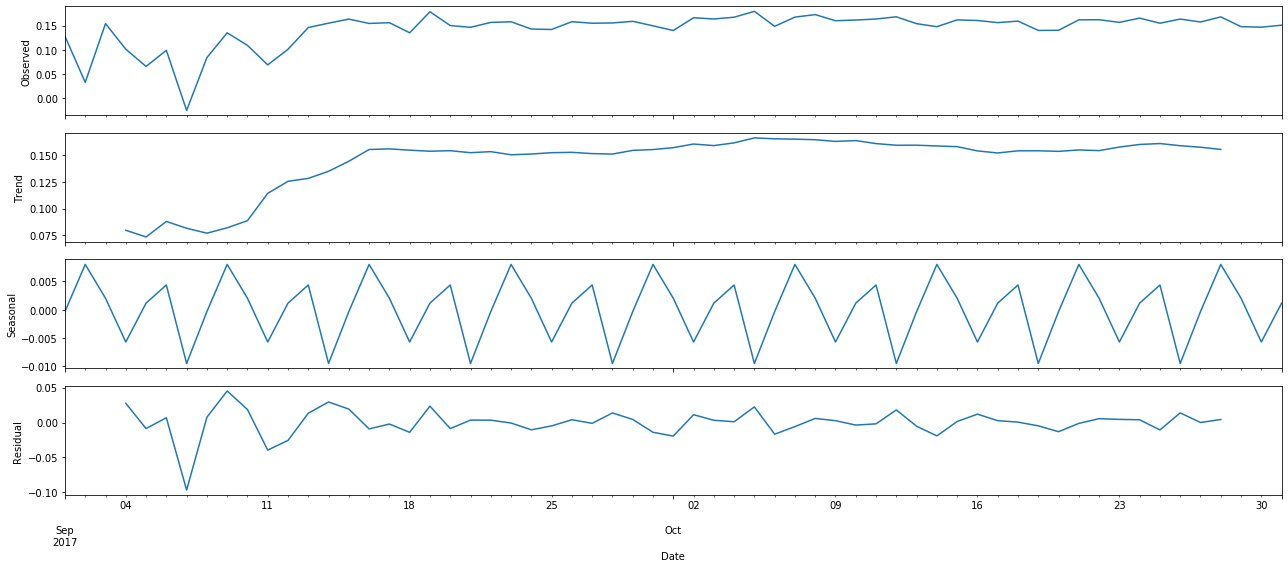

In [149]:
display_seasonal_decompose(tsdf_apple)

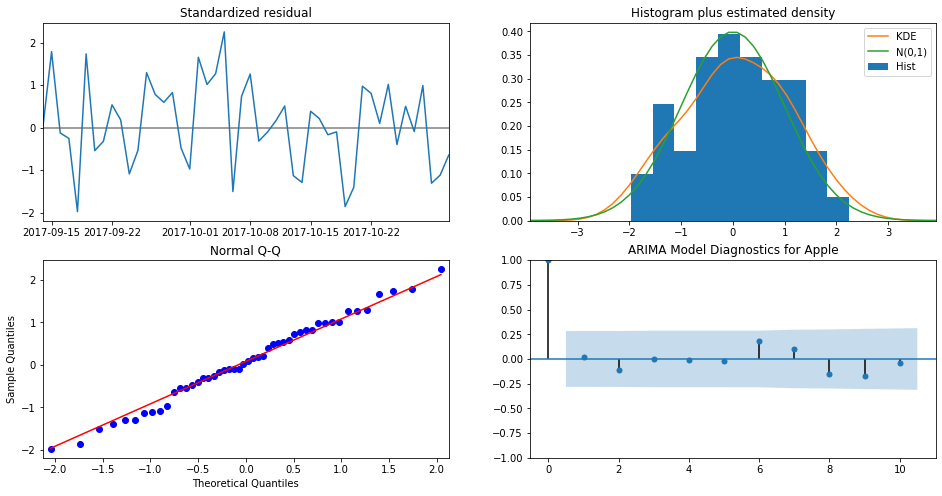

In [150]:
results = fit_ARIMA_model(tsdf_apple, 'apple')

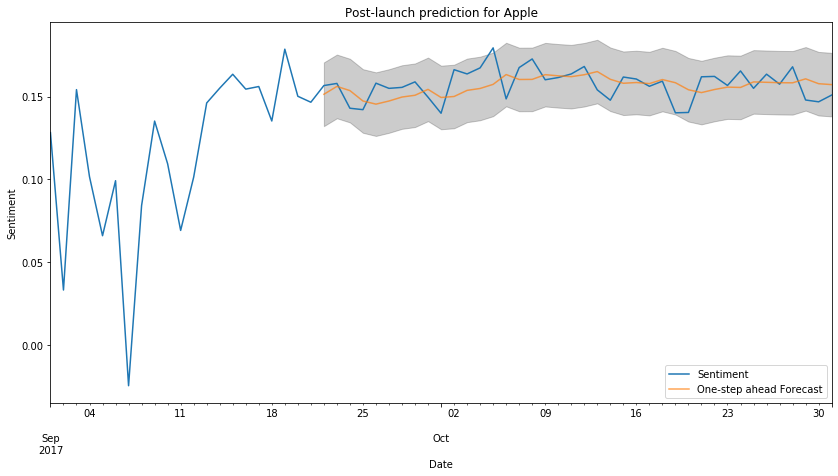

In [151]:
predict_post_launch(results, tsdf_apple, 'apple')

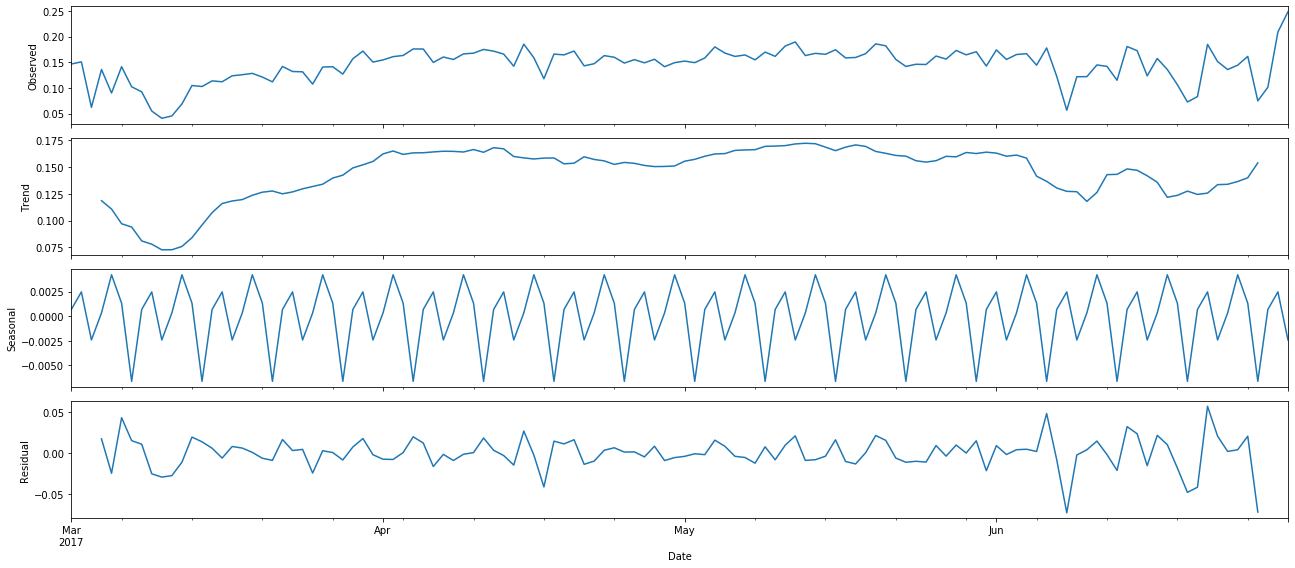

In [152]:
display_seasonal_decompose(tsdf_samsung)

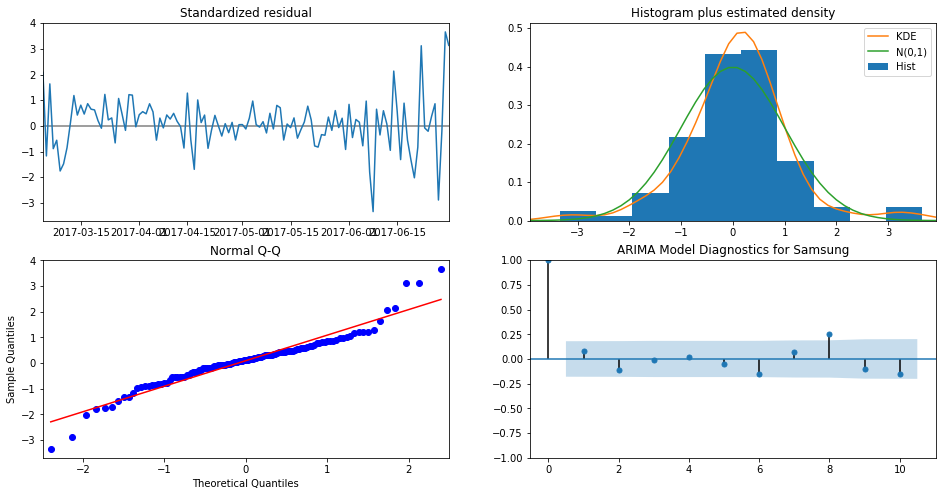

In [153]:
results = fit_ARIMA_model(tsdf_samsung, 'samsung')

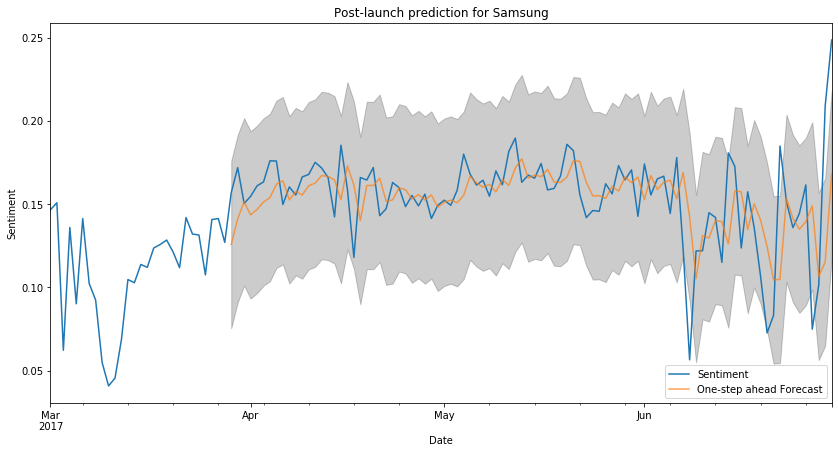

In [154]:
predict_post_launch(results, tsdf_samsung, 'samsung')